In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# Read and check data Sources

In this anomaly detector, I will use the store and sales data

In [2]:
data = pd.read_csv('train.csv')
stores = pd.read_csv('store.csv', index_col=0)

/home/shaheen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
data['Store'].nunique()

1115

In [6]:
stores.head()

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Just filling some NaN. 

In [7]:
stores['Promo2SinceYear'].fillna(stores['Promo2'], inplace=True)
stores['Promo2SinceWeek'].fillna(stores['Promo2'],inplace=True)

## Creating a unique datafram

In [8]:
tot_data = pd.merge(data,stores,how='inner',on='Store')

In [9]:
tot_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN


# Visualization 
## Here, I will just check informations from the data

/home/shaheen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


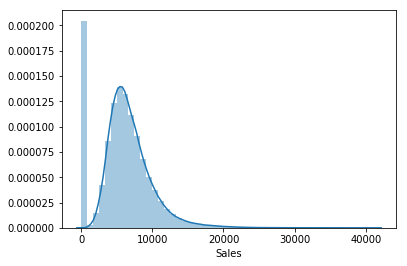

In [10]:
sns.distplot(tot_data['Sales'])

Obviously, sales are very correlated with the number of customers

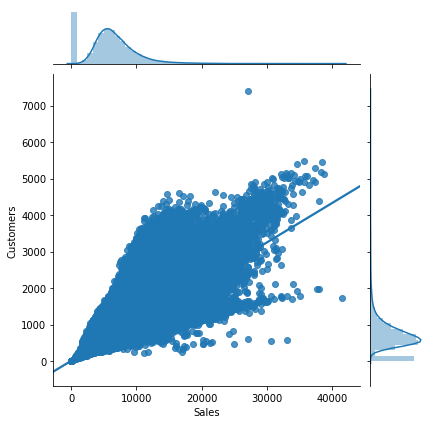

In [11]:
sns.jointplot(x='Sales',y='Customers',data=data,kind='reg')

Not that much with the distance between Rossmann stores and the nearest competitor store

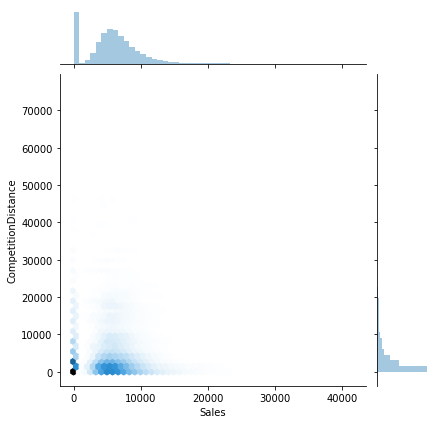

In [12]:
sns.jointplot(x='Sales',y='CompetitionDistance',data=tot_data, kind='hex')

The store type is only relevant for the **b** type's store.

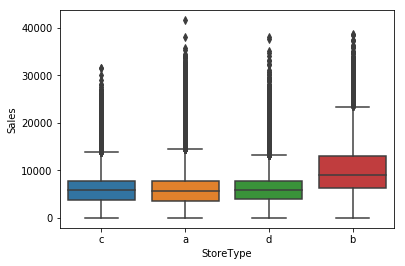

In [13]:
sns.boxplot(x='StoreType',y='Sales', data=tot_data)

The presence or not of a promotion should be taken into account

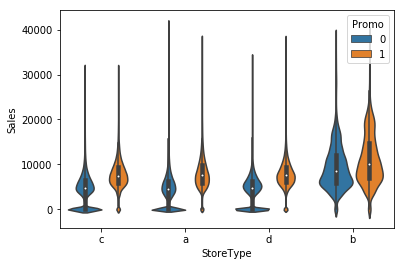

In [14]:
sns.violinplot(x='StoreType',y='Sales', data=tot_data,hue='Promo')

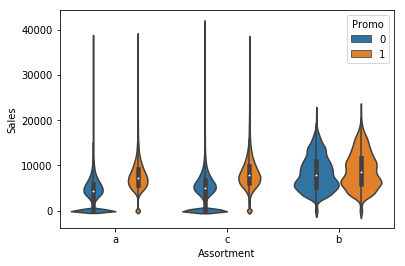

In [15]:
sns.violinplot(x='Assortment',y='Sales', data=tot_data, hue='Promo')

Obviously the four relevant data to explain sales are:
- The number of costumers
- If the store is open or not
- If a promotion is running or not

Otherwise, the correlation are not that relevant for a first attempt. I should take into account the store's type and the Assortment variable.

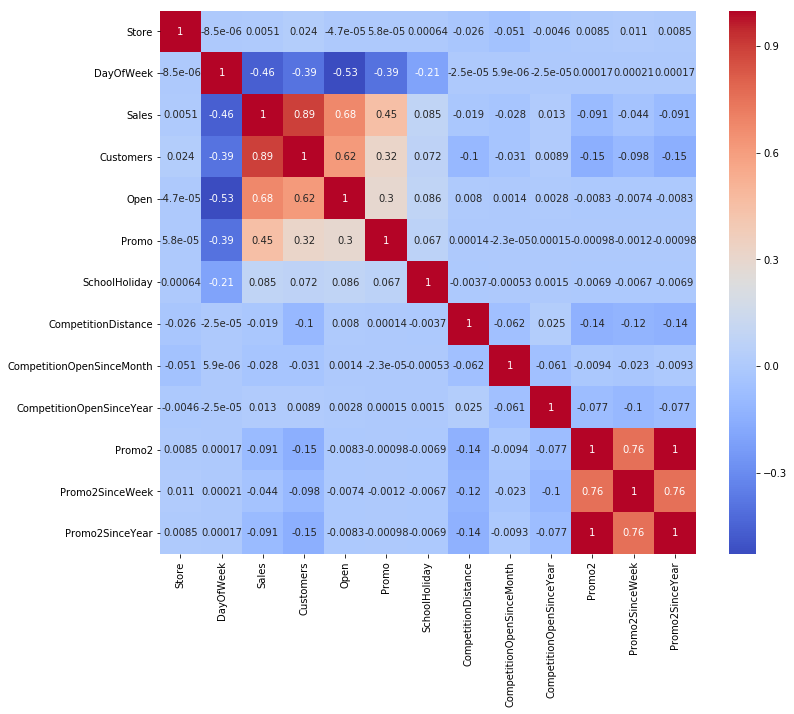

In [16]:
fig, ax = plt.subplots(figsize=(12,10))  
sns.heatmap(tot_data.corr(),annot=True, cmap='coolwarm')

Since only the b type's store and the b assortment are relevant, I can create a dummy variable to take them into account

In [17]:
dummies = pd.get_dummies(tot_data['StoreType']).rename(columns=lambda x: 'StoreType_' + str(x))
tot_data = pd.concat([tot_data, dummies['StoreType_b']], axis=1)
tot_data.drop(['StoreType'], inplace=True, axis=1)
dummies = pd.get_dummies(tot_data['Assortment']).rename(columns=lambda x: 'Assortment_' + str(x))
tot_data = pd.concat([tot_data, dummies['Assortment_b']], axis=1)
tot_data.drop(['Assortment'], inplace=True, axis=1)


# First attempt
I will use the K means algorithm to categorize data into clusters. The K-means algorithm is interesting since it is a unsupervised machine-learning algorithm.  
I choosed it because I don't really know what is an anomaly in my data.

Once the K-means algorithm find the clusters, an anomaly is defined as a point being too far away from the center of the nearest cluster.

In [18]:
from sklearn.cluster import KMeans
from sklearn import preprocessing


The data files being huge, I will nt train my model on all the data.

In [46]:
dataML = tot_data[['Sales','Customers','Open','Promo', 'StoreType_b', 'Assortment_b']]
dataML = dataML.truncate(before=0, after= 100000)

In [47]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(dataML)
dataML = pd.DataFrame(np_scaled)


/home/shaheen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/shaheen/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Check the _right_ number of cluster

I use the elbows technic to find the right number of cluster.

In [48]:
clusterNumb = range(1,20)
kmeans = [KMeans(n_clusters=i).fit(dataML) for i in clusterNumb]
scores = [kmeans[i].score(dataML) for i in range(len(kmeans))]

According to the following figure, a good number of cluster is arround 7.

Text(0, 0.5, 'Kmeans score')

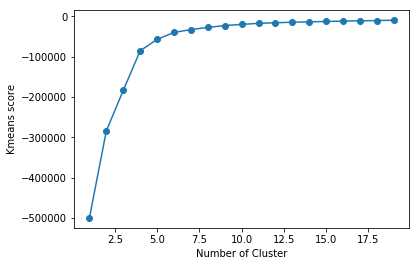

In [49]:
fig, ax = plt.subplots()
ax.plot(clusterNumb, scores,"o-")
ax.set_xlabel('Number of Cluster')
ax.set_ylabel('Kmeans score')

## Some statistics

Now that I choosed the number of cluster in my K-means algorithm, I will check the mean distance and the standard deviation between points and cluster centers. An anomaly is defined as a point being at a larger distance than the sum of the mean distance and the standard deviation of the nearest cluster. 

In [50]:
def distanceFunction(position, center):
    return np.linalg.norm(position- center)

def distMin(position, centers):
    d = np.zeros(len(centers))
    for i in range(len(centers)):
        d[i] = distanceFunction(position, centers[i])
    return d.min(),int(d.argmin())

In [51]:
posMin = np.zeros(len(np_scaled))
clusterMin = np.zeros(len(np_scaled))
for i in range(len(np_scaled)):
    posMin[i],clusterMin[i] = distMin(np_scaled[i], kmeans[6].cluster_centers_)
stat_info = list(zip(clusterMin, posMin))

I am not proud of the following function. Surely, it exists a more pythonic way to do it.

In [52]:
def get_info_clu(stat_info, cluster):
    temp = []
    for i in range(len(stat_info)):
        if(stat_info[i][0]==cluster):
            temp.append(stat_info[i][1])
    temp = np.array(temp)
    return temp.mean(), temp.std()

In [53]:
print('Average distance from the nearest cluster = ', posMin.mean())
print('Standard deviation from the nearest cluster = ', posMin.std())

Average distance from the nearest cluster =  0.4484526421918243
Standard deviation from the nearest cluster =  0.3599090686978424


In [54]:
for i in range(len(kmeans[6].cluster_centers_)):
    print('Average distance from point belonging to the cluster '+str(i)+': ',get_info_clu(stat_info,i)[0])
    print('Standard deviation from point belonging to the cluster '+str(i)+': ',get_info_clu(stat_info,i)[1])

Average distance from point belonging to the cluster 0:  0.40564119934982645
Standard deviation from point belonging to the cluster 0:  0.22654530314804974
Average distance from point belonging to the cluster 1:  0.49155287643490964
Standard deviation from point belonging to the cluster 1:  0.2262085703223645
Average distance from point belonging to the cluster 2:  0.2537177125784278
Standard deviation from point belonging to the cluster 2:  0.44359093137109035
Average distance from point belonging to the cluster 3:  1.3396207674104195
Standard deviation from point belonging to the cluster 3:  0.48306914071094526
Average distance from point belonging to the cluster 4:  0.6002357566900056
Standard deviation from point belonging to the cluster 4:  0.34696707768613627
Average distance from point belonging to the cluster 5:  0.3908362346570024
Standard deviation from point belonging to the cluster 5:  0.20002141041872198
Average distance from point belonging to the cluster 6:  0.9498907595

# Standarization de la procedure

I will create a structure to carry all the important function and variable in a very compact form. 
###### Sometimes I miss C.

In [57]:
class myStruct:
    pass

myStruct.scaler = min_max_scaler.transform
myStruct.statInfo = get_info_clu
myStruct.cluster_center = kmeans[6].cluster_centers_
myStruct.Info = stat_info
myStruct.distMean = [myStruct.statInfo(myStruct.Info, i)[0] for i in range(len(myStruct.cluster_center))]
myStruct.distStd = [myStruct.statInfo(myStruct.Info, i)[1] for i in range(len(myStruct.cluster_center))]
myStruct.distFunc = distanceFunction
myStruct.distMin = distMin

In [60]:
def isAnomaly(dataL, struct):
    distanceFromCluster, Cluster = struct.distMin(dataL, struct.cluster_center)
    if(distanceFromCluster > struct.distMean[Cluster]+struct.distStd[Cluster]):
        return True
    return False

def fromDataF(dataF, struct):
    scaled = struct.scaler(dataF[['Sales','Customers','Open','Promo','StoreType_b','Assortment_b']])
    dataF["Anomaly"] = [isAnomaly(scaled[i], struct) for i in range(len(scaled))]
    return dataF

Test on the whole data set:

In [61]:
test = fromDataF(tot_data, myStruct)

/home/shaheen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


According to my anomaly detector, there is arround 20% of anomalies from Rossmann dataset. It is too much and a lot of improvement could be done:
- taking into account store's type and assortment. In this first attempt, I didn't take into account those categorical variables.
- using a better criteria for the anomaly.
- using a better model.

In [62]:
test['Anomaly'].value_counts()

False    841826
True     175383
Name: Anomaly, dtype: int64

## Thank you